# Sea-Ice Detection with Micron Sonar

In [105]:
# import external libraries
import csv
import datetime
import dateutil
import dill
import importlib
import pandas as pd
import plotly.express as px
import math
import numpy as np
import os
import seaborn as sns 
import sys
from PIL import Image
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import micron_plotter
import MicronSonar
import MicronEnsemble
import MicronTimeSeries

# use Seaborn settings for plotting 
sns.set()

# set warning preferences for pandas
pd.set_option('mode.chained_assignment', 'raise')

# define function for reloading modules
def reload_modules():
    importlib.reload(MicronSonar)
    importlib.reload(MicronEnsemble)
    importlib.reload(MicronTimeSeries)
    importlib.reload(micron_plotter)

---
## 0. Properties of Sea-ice, Seawater, and Air

In [1218]:
DEG_TO_RAD = np.pi/180

c_dict = {
    'ice':c_seaice,
    'wat':c_water,
    'air':c_air
}

rho_dict = {
    'ice':rho_seaice,
    'wat':rho_water,
    'air':rho_air,
}

def R(material_1, material_2, incidence):
    """Determine reflection coefficient R"""
    rho1        = rho_dict[material_1]
    c1          = c_dict[material_1]
    rho2        = rho_dict[material_2]
    c2          = c_dict[material_2]
    theta1      = abs(incidence-90)
    term1       = (rho2/rho1)*np.sin(theta1*DEG_TO_RAD)
    term2       = ((c1/c2)**2 - (np.cos(theta1*DEG_TO_RAD)**2))**0.5
    numerator   = term1 - term2
    denominator = term1 + term2
    R           = numerator/denominator
    return(R)
    
def T(material_1, material_2, incidence):
    """Determine transmission coefficient T"""
    rho1        = rho_dict[material_1]
    c1          = c_dict[material_1]
    rho2        = rho_dict[material_2]
    c2          = c_dict[material_2]
    theta1      = abs(incidence-90)
    term1       = (rho2/rho1)*np.sin(theta1*DEG_TO_RAD)
    term2       = ((c1/c2)**2 - (np.cos(theta1*DEG_TO_RAD)**2))**0.5
    numerator   = term1*2
    denominator = term1 + term2
    T           = numerator/denominator
    return(T)

# density information
rho_water  = 1028     # [kg][m]^-3
rho_seaice =  910     # [kg][m]^-3
rho_air    =    1.225 # [kg][m]^-3

# speed of sound information 
c_water    = 1450     # [m][s]^-1
c_seaice   = 3845     # [m][s]^-1
c_air      =  343     # [m][s]^-1

In [1219]:
print('Critical Angle from Air to Water:     %0.5f' % (90 - np.arccos(c_air/c_water)*180/np.pi))
print('Critical Angle from Air to Sea-ice:   %0.5f' % (90 - np.arccos(c_air/c_seaice)*180/np.pi))
print('Critical Angle from Water to Sea-ice: %0.5f\n' % (90 - np.arccos(c_water/c_seaice)*180/np.pi))
print("Water to Air:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('wat', 'air', 0), T('wat', 'air', 0)))
print("Air to Water:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('air', 'wat', 0), T('air', 'wat', 0)))
print("Water to Sea-ice:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('wat', 'ice', 0), T('wat', 'ice', 0)))
print("Sea-ice to Water:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('ice', 'wat', 0), T('ice', 'wat', 0)))
print("Sea-ice to Air:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('ice', 'air', 0), T('ice', 'air', 0)))
print("Air to Sea-ice:")
print('  R: %0.2f \n  T: %0.2f \n' %(R('air', 'ice', 0), T('air', 'ice', 0)))
# print("Air to Water:")
# print('  R: %0.3f \n  T: %0.3f' %(R('air', 'wat', 0), T('air', 'wat', 0)))

Critical Angle from Air to Water:     13.68311
Critical Angle from Air to Sea-ice:   5.11797
Critical Angle from Water to Sea-ice: 22.15498

Water to Air:
  R: -1.00 
  T: 0.00 

Air to Water:
  R: 1.00 
  T: 2.00 

Water to Sea-ice:
  R: 0.40 
  T: 1.40 

Sea-ice to Water:
  R: -0.40 
  T: 0.60 

Sea-ice to Air:
  R: -1.00 
  T: 0.00 

Air to Sea-ice:
  R: 1.00 
  T: 2.00 



---
## 1. Parse Micron Sonar file

In [310]:
reload_modules()
ext  = ".CSV"

#############################################
# STEP 1: set file parameters ###############


#############################################
# WHOI TANK TEST ############################
# folder = "2020-01-24_WHOI-Tank/csv/"
# date   = (2020, 1, 24)
# constant_depth    = 0.4
# constant_altitude = 0.2
# file = "Fri_24_Jan_13_34"  # WH PIC 0  
# file = "Fri_24_Jan_14_30"  # WH PIC A 
# file = "Fri_24_Jan_14_42"  # WH PIC B
# file = "Fri_24_Jan_14_55"  # WH PIC C
# file = "Fri_24_Jan_15_08"  # WH PIC D 
# file = "Fri_24_Jan_15_20"  # WH PIC E
# file = "Fri_24_Jan_15_33"  # WH PIC F
# file = "Fri_24_Jan_15_50"  # WH PIC G


#############################################
# SAINT-FABIEN FIELD TEST - DAY 2 ###########
folder = "2020-02-11_Saint-Fabien-Day2/csv/"
date   = (2020, 2, 11)
constant_depth    = None
constant_altitude = None
# file = "Tue_11_Feb_16_24" # SF PIC 0.A
# file = "Tue_11_Feb_16_26" # SF PIC 0.B
# file = "Tue_11_Feb_16_31" # SF PIC 0.C
# file = "Tue_11_Feb_16_33" # SF PIC 0.D
# file = "Tue_11_Feb_16_15" # SF PIC A
# file = "Tue_11_Feb_16_11" # SF PIC B
# file = "Tue_11_Feb_16_07" # SF PIC C
# file = "Tue_11_Feb_16_02" # SF PIC D
# file = "Tue_11_Feb_15_54" # SF PIC E


#############################################
# SAINT-FABIEN FIELD TEST - DAY 3 ###########
folder = "2020-02-12_Saint-Fabien-Day3/csv/"
date   = (2020, 2, 12)
constant_depth    = None
constant_altitude = None
# AFTER LUNCH -- PARSE WATER CONTACT PIC
file = "Wed_12_Feb_13_35" # SF A
file = "Wed_12_Feb_13_37" # SF B


#############################################
# STEP 2: parse file ########################
root     = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/Micron Sonar/"
filepath = "%s%s%s%s" % (root, folder, file, ext)
ts = MicronTimeSeries.MicronTimeSeries.from_raw_csv(
    filepath, 
    date=date,
    bearing_bias=0,
    constant_depth=constant_depth,
    constant_altitude=constant_altitude
)


#############################################
# STEP 3: crop file #########################
left_limit  = -60
right_limit =  60
ts_cropped  = ts.crop_on_bearing(left_limit, right_limit)
ts_swath    = ts.crop_on_bearing(left_limit, right_limit, single_swath=True)

Parsing: Wed_12_Feb_13_37
  >> Ensembles Parsed:   100
  >> Ensembles Parsed:   200
  >> Finished Parsing!


---
## 2. Define Separator and Set Sea-ice Labels Appropriately

In [316]:
reload_modules()
make_polar_plot     = True
make_incidence_plot = True
make_polar_plot     = False
make_incidence_plot = False
min_bearing = -180
max_bearing =  180


#############################################
# STEP 1: set separator #####################
"""
#############################################
# Labels to Consider ########################
    'label_ice_category',   # user specified label  for ice-category
    'label_ice_presence',   # user specified label  for ice-presence
    'label_ice_percent',    # user specified label  for ice-percentage
    'label_ice_thickness',  # user specified label  for ice-thickness 
    'label_ice_slope',      # user specified label  for ice-slope
    'label_ice_roughness',  # user specified label  for ice-roughness
    'label_saltwater_flag'  # value 1 means saltwater, 0 freshwater
"""


#############################################
# SF Field Test -- PIC 0 D ##################
separator   = -3
pad         =  0.0
min_bearing = -60
max_bearing =  60
labels = [
    # free-surface side
    ('label_ice_category',    30, min_bearing, separator,   pad),
    ('label_ice_presence',     1, min_bearing, separator,   pad),
    ('label_ice_percent',  100.0, min_bearing, separator,   pad),
    # ice-floe side 
    ('label_ice_category',    21, separator,   max_bearing, pad),
    ('label_ice_presence',     1, separator,   max_bearing, pad),
    ('label_ice_percent',  100.0, separator,   max_bearing, pad),
]


#############################################
# STEP 3: generate polar plot ###############
if make_polar_plot:
    micron_plotter.plot_polar(
        ts_swath, 
        separator=separator, 
        pad=pad,
        output_file=ts_swath.name+"_polar",
        sonar_depth = 1.2
    )
    
    
#############################################
# STEP 4: set labels ########################
ts_cropped.reset_labels()
ts_swath.reset_labels()
for (var, val, b_min, b_max, pad) in labels:
    ts_cropped.set_label_by_bearing(var, val, b_min, b_max, pad)
    ts_swath.set_label_by_bearing(var, val, b_min, b_max, pad)

     
#############################################
# STEP 5: generate incidence plot ###########
if make_incidence_plot:
    micron_plotter.plot_incidence_curves(
        ts_cropped, 
        variable_size=False,
        output_file=ts_cropped.name+"_incidence",
        axis_limits=False
    )
print("Done!")

Done!


---
## 3. Save Labeled Data 

In [315]:
ts_cropped.df.to_csv('/Users/zduguid/Desktop/dat/MSIS-labeled-data/2-SF-tmp.csv')
# labeled_data_settings[file]      = labels
# labeled_data_time_series[file]   = ts_cropped
# ts_cropped.save_as_csv(directory ='../csv/TimeSeries_')
# print(len(labeled_data_settings))
# print(labeled_data_settings.keys())

---
## 4. Sea-ice Classification with Labeled Data

In [319]:
reload_modules()
file_dir  = "/Users/zduguid/Desktop/dat/MSIS-labeled-data/"
msis_ts   = MicronTimeSeries.MicronTimeSeries.from_csv_directory(file_dir, 'labeled_data')
msis_df   = msis_ts.df

Parsing folder of CSV files
>> Parsing: 0-WH-tank-PIC-A
>> Parsing: 0-WH-tank-PIC-B
>> Parsing: 0-WH-tank-PIC-C
>> Parsing: 0-WH-tank-PIC-G
>> Parsing: 0-WH-tank-PIC-F
>> Parsing: 0-WH-tank-PIC-0
>> Parsing: 0-WH-tank-PIC-D
>> Parsing: 0-WH-tank-PIC-E
>> Parsing: 2-SF-B
>> Parsing: 2-SF-A
>> Parsing: 1-SF-PIC-B
>> Parsing: 1-SF-PIC-C
>> Parsing: 1-SF-PIC-A
>> Parsing: 1-SF-PIC-0-D
>> Parsing: 1-SF-PIC-D
>> Parsing: 1-SF-PIC-0-A
>> Parsing: 1-SF-PIC-E
>> Parsing: 1-SF-PIC-0-C
>> Parsing: 1-SF-PIC-0-B
>> Finished Parsing!


### 4.A. Set handles for Specific Testing Days

In [321]:
print("Num Tank Test Points:  %5d" % len(msis_df['2020-01']))
print("Num Field Test Points: %5d" % len(msis_df['2020-02']))
msis_tank  = msis_df['2020-01']
msis_field = msis_df['2020-02']
WH_day1 = msis_df['2020-01-24']
SF_day1 = msis_df['2020-02-10']
SF_day2 = msis_df['2020-02-11']
SF_day3 = msis_df['2020-02-12']
SF_day4 = msis_df['2020-02-13']

# data with hand-annotated on sea-ice labels
msis_labeled = msis_df[(msis_df.label_ice_presence==1.0) |
                       (msis_df.label_ice_presence==0.0)].copy()

Num Tank Test Points:  20871
Num Field Test Points:   877


### 4.B. Plot Extracted Features

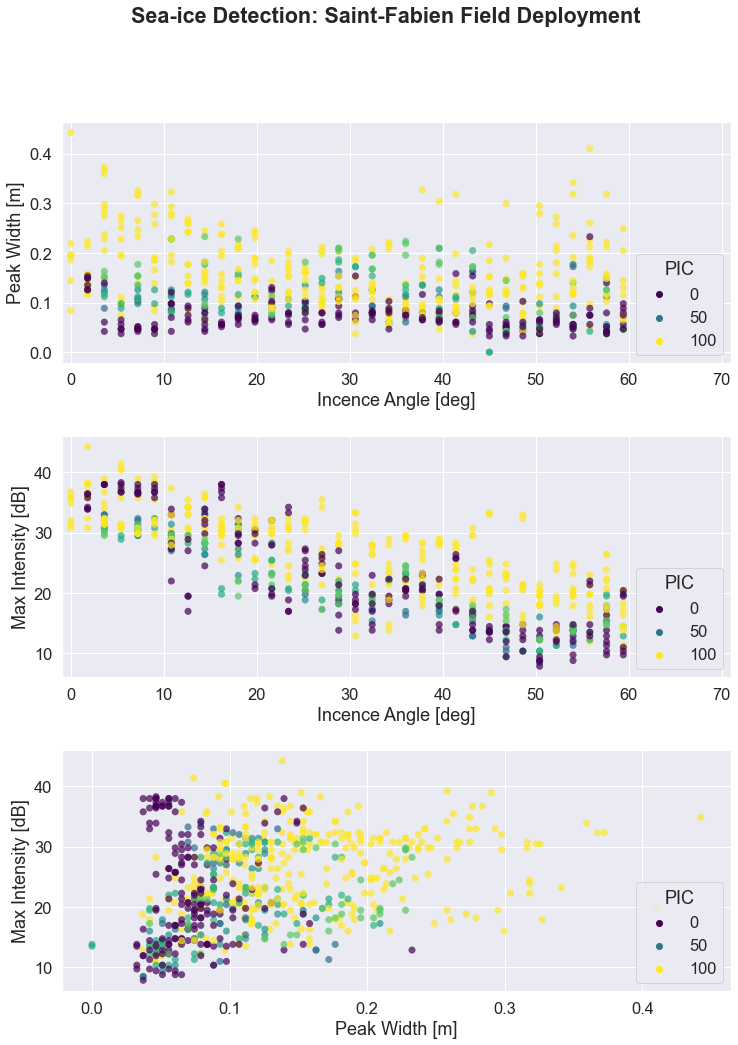

In [1214]:
fig, ax = plt.subplots(3,1,figsize=(12,16))
palette = 'viridis'
s=50
ALPHA=0.7
df = msis_labeled['2020-02']
# df = msis_tank
# df = msis_df

sns.scatterplot(
    df.incidence_angle, 
    df.peak_width,
    df.label_ice_percent,
    s=s,
    ax=ax[0],
    linewidth=0,
    palette=palette,
    alpha=ALPHA,
#     legend=False,
)

sns.scatterplot(
    df.incidence_angle, 
    df.max_intensity,
    df.label_ice_percent,
    s=s,
    ax=ax[1],
    linewidth=0,
    palette=palette,
    alpha=ALPHA,
    legend=False,)

sns.scatterplot(
    df.peak_width, 
    df.max_intensity,
    df.label_ice_percent,
    s=s,
    ax=ax[2],
    linewidth=0,
    palette=palette,
    alpha=ALPHA,
    legend=False)

# lgnd = ax.legend(frameon=True)
handles, labels = ax[0].get_legend_handles_labels()
new_handles = handles[1:3]
new_handles.extend([handles[-1]])
new_labels = ['0', '50', '100']
ax[0].legend(title='PIC', handles=new_handles, labels=new_labels, loc='lower right')
ax[1].legend(title='PIC', handles=new_handles, labels=new_labels, loc='lower right')
ax[2].legend(title='PIC', handles=new_handles, labels=new_labels, loc='lower right')
ax[0].set_xlim(-1,71)
ax[1].set_xlim(-1,71)
# ax[0].set_xlim(0,70)

ax[0].set_xlabel('Incence Angle [deg]')
ax[1].set_xlabel('Incence Angle [deg]')
ax[2].set_xlabel('Peak Width [m]')
ax[0].set_ylabel('Peak Width [m]')
ax[1].set_ylabel('Max Intensity [dB]')
ax[2].set_ylabel('Max Intensity [dB]')
plt.subplots_adjust(hspace=0.3)
plt.suptitle('Sea-ice Detection: Saint-Fabien Field Deployment', fontweight='bold')
# plt.suptitle('Sea-ice Detection: Woods Hole Tank Test', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')


### 4.C. Plot Sea-ice Labels

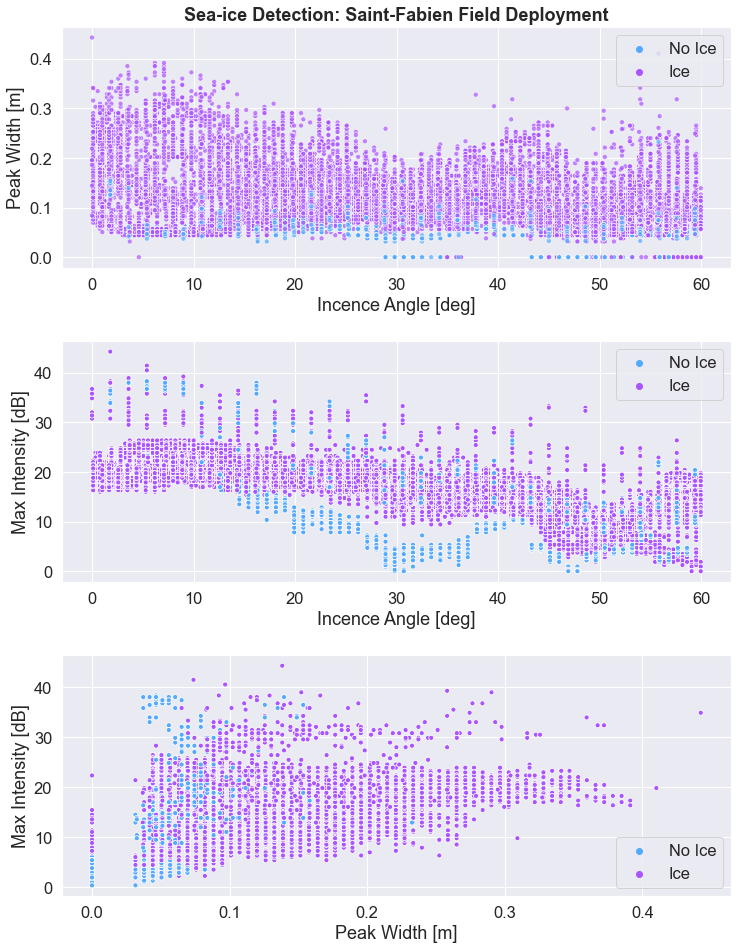

In [1207]:
fig, ax = plt.subplots(3,1,figsize=(12,16))
palette = 'cool'
s=25
# s=35
# df = msis_field
# df = msis_tank
df = msis_labeled

sns.scatterplot(
    df.incidence_angle, 
    df.peak_width,
    df.label_ice_presence,
    alpha=0.7,
    s=s,
    ax=ax[0],
    palette=palette,
#     legend=False,
)

sns.scatterplot(
    df.incidence_angle, 
    df.max_intensity,
    df.label_ice_presence,
    s=s,
    ax=ax[1],
    palette=palette,
    legend=False,)

sns.scatterplot(
    df.peak_width, 
    df.max_intensity,
    df.label_ice_presence,
    s=s,
    ax=ax[2],
    palette=palette,
    legend=False)

# lgnd = ax.legend(frameon=True)
handles, labels = ax[0].get_legend_handles_labels()
new_handles = handles[1:]
new_labels = ['No Ice', 'Ice']
ax[0].legend(handles=new_handles, labels=new_labels, loc='upper right')
ax[1].legend(handles=new_handles, labels=new_labels, loc='upper right')
ax[2].legend(handles=new_handles, labels=new_labels, loc='lower right')

ax[0].set_xlabel('Incence Angle [deg]')
ax[1].set_xlabel('Incence Angle [deg]')
ax[2].set_xlabel('Peak Width [m]')
ax[0].set_ylabel('Peak Width [m]')
ax[1].set_ylabel('Max Intensity [dB]')
ax[2].set_ylabel('Max Intensity [dB]')
plt.subplots_adjust(hspace=0.3)
ax[0].set_title('Sea-ice Detection: Saint-Fabien Field Deployment', fontweight='bold')
# ax[0].set_title('Sea-ice Detection: Woods Hole Tank Test', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')

### 4.D. Plot Results of Classification 

In [1119]:
def classifier(peak_width, incidence_angle, max_intensity):
    # FPR = 6percent
    if peak_width > 0.12:
        return(1)
    else:
        return(0)
    
print('Field Classifier')
classifications = []
for i in range(len(msis_labeled)):
    peak_width      = msis_labeled.peak_width[i]
    incidence_angle = msis_labeled.incidence_angle[i]
    max_intensity   = msis_labeled.max_intensity[i]
    classifications.append(field_classifier(peak_width, incidence_angle, max_intensity))

new_classifications = np.array(pd.Series(classifications).rolling(10, center=True, min_periods=1).mean())
threshold=0.1
new_classifications[new_classifications>=threshold] = 1
new_classifications[new_classifications<threshold] = 0
msis_labeled['class_ice_presence'] = new_classifications
print('Done')

Field Classifier
Done


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


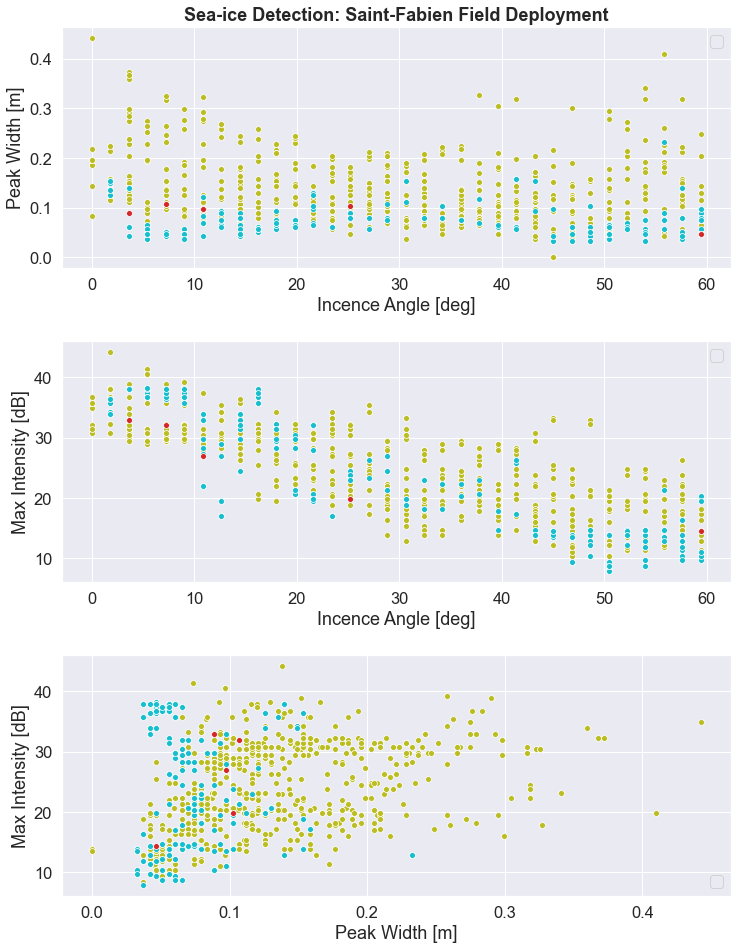

In [1120]:
fig, ax = plt.subplots(3,1,figsize=(12,16))
palette = 'hsv'
# s=15
s=35
# df = msis_field
# df = msis_tank
df = msis_labeled['2020-02']


false_positives = df[(df.class_ice_presence==1)&
                     (df.label_ice_presence==0)]


false_negatives = df[(df.class_ice_presence==0)&
                     (df.label_ice_presence==1)]


# false_negatives = df[(df.class_ice_presence==0)&
#                      (df.label_ice_presence==1)]


sns.scatterplot(
    df.incidence_angle, 
    df.peak_width,
    color='tab:olive',
    s=s,
    ax=ax[0],
#     legend=False,
)


sns.scatterplot(
    false_positives.incidence_angle, 
    false_positives.peak_width,
    color='tab:cyan',
    s=s,
    ax=ax[0],
)


sns.scatterplot(
    false_negatives.incidence_angle, 
    false_negatives.peak_width,
    color='tab:red',
    s=s,
    ax=ax[0],
)


sns.scatterplot(
    df.incidence_angle, 
    df.max_intensity,
    color='tab:olive',
    s=s,
    ax=ax[1],
    legend=False,)


sns.scatterplot(
    false_positives.incidence_angle, 
    false_positives.max_intensity,
    color='tab:cyan',
    s=s,
    ax=ax[1],
)


sns.scatterplot(
    false_negatives.incidence_angle, 
    false_negatives.max_intensity,
    color='tab:red',
    s=s,
    ax=ax[1],
)


sns.scatterplot(
    df.peak_width, 
    df.max_intensity,
    color='tab:olive',
    s=s,
    ax=ax[2],
    legend=False)


sns.scatterplot(
    false_positives.peak_width, 
    false_positives.max_intensity,
    color='tab:cyan',
    s=s,
    ax=ax[2],
)


sns.scatterplot(
    false_negatives.peak_width, 
    false_negatives.max_intensity,
    color='tab:red',
    s=s,
    ax=ax[2],
)


# lgnd = ax.legend(frameon=True)
handles, labels = ax[0].get_legend_handles_labels()
new_handles = handles[1:]
new_labels = ['No Ice', 'Ice']
ax[0].legend(handles=new_handles, labels=new_labels, loc='upper right')
ax[1].legend(handles=new_handles, labels=new_labels, loc='upper right')
ax[2].legend(handles=new_handles, labels=new_labels, loc='lower right')

ax[0].set_xlabel('Incence Angle [deg]')
ax[1].set_xlabel('Incence Angle [deg]')
ax[2].set_xlabel('Peak Width [m]')
ax[0].set_ylabel('Peak Width [m]')
ax[1].set_ylabel('Max Intensity [dB]')
ax[2].set_ylabel('Max Intensity [dB]')
plt.subplots_adjust(hspace=0.3)
ax[0].set_title('Sea-ice Detection: Saint-Fabien Field Deployment', fontweight='bold')
# ax[0].set_title('Sea-ice Detection: Woods Hole Tank Test', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')

In [760]:
def classifier(peak_width, incidence_angle, max_intensity):
    if peak_width > 0.05:
        return(1)
    else:
        return(0)


In [858]:
pw_list = np.arange(0.04, 0.2, 0.01)
tank_TPR_list  = []
tank_FPR_list  = []
field_TPR_list = []
field_FPR_list = []

In [861]:
for pw in pw_list:
    
    print(pw)
    def classifier(peak_width, incidence_angle, max_intensity):
        if peak_width > pw:
            return(1)
        else:
            return(0)

    classifications = []

    for i in range(len(msis_labeled)):
        peak_width      = msis_labeled.peak_width[i]
        incidence_angle = msis_labeled.incidence_angle[i]
        max_intensity   = msis_labeled.max_intensity[i]
        classifications.append(classifier(peak_width, incidence_angle, max_intensity))

    msis_labeled['class_ice_presence'] = classifications


    class_tank  = msis_labeled['2020-01']
    class_field = msis_labeled['2020-02']

    # tank_true_positive_count  = sum(class_tank.label_ice_presence==1 & 
    #                                 class_tank.class_ice_presence==1)



    tank_true_positive_count   = len(class_tank[(class_tank.label_ice_presence==1) & 
                                                (class_tank.class_ice_presence==1)])

    tank_false_positive_count  = len(class_tank[(class_tank.label_ice_presence==0) & 
                                                (class_tank.class_ice_presence==1)])

    tank_positive_count        = len(class_tank[class_tank.label_ice_presence==1])
    tank_negative_count        = len(class_tank[class_tank.label_ice_presence==0])

    tank_TPR                   = tank_true_positive_count/tank_positive_count
    tank_FPR                   = tank_false_positive_count/tank_negative_count

    field_true_positive_count  = len(class_field[(class_field.label_ice_presence==1) & 
                                                 (class_field.class_ice_presence==1)])

    field_false_positive_count = len(class_field[(class_field.label_ice_presence==0) & 
                                                 (class_field.class_ice_presence==1)])

    field_positive_count       = len(class_field[class_field.label_ice_presence==1])
    field_negative_count       = len(class_field[class_field.label_ice_presence==0])

    field_TPR                  = field_true_positive_count/field_positive_count
    field_FPR                  = field_false_positive_count/field_negative_count

    print('Tank  FPR: %0.3f \nTank  TPR: %0.3f\n' % (tank_FPR,  tank_TPR))
    print('Field FPR: %0.3f \nField TPR: %0.3f\n' % (field_FPR, field_TPR))
    
    tank_TPR_list.append(tank_TPR)
    tank_FPR_list.append(tank_FPR)
    field_TPR_list.append(field_TPR)
    field_FPR_list.append(field_FPR)



0.04
Tank  FPR: 0.734 
Tank  TPR: 0.993

Field FPR: 0.945 
Field TPR: 0.988

0.05
Tank  FPR: 0.486 
Tank  TPR: 0.957

Field FPR: 0.809 
Field TPR: 0.954

0.060000000000000005
Tank  FPR: 0.185 
Tank  TPR: 0.871

Field FPR: 0.661 
Field TPR: 0.921

0.07
Tank  FPR: 0.050 
Tank  TPR: 0.786

Field FPR: 0.437 
Field TPR: 0.883

0.08000000000000002
Tank  FPR: 0.005 
Tank  TPR: 0.746

Field FPR: 0.251 
Field TPR: 0.830

0.09000000000000001
Tank  FPR: 0.000 
Tank  TPR: 0.663

Field FPR: 0.175 
Field TPR: 0.768

0.1
Tank  FPR: 0.000 
Tank  TPR: 0.620

Field FPR: 0.126 
Field TPR: 0.697

0.11000000000000001
Tank  FPR: 0.000 
Tank  TPR: 0.544

Field FPR: 0.093 
Field TPR: 0.650

0.12000000000000002
Tank  FPR: 0.000 
Tank  TPR: 0.472

Field FPR: 0.082 
Field TPR: 0.556

0.13000000000000003
Tank  FPR: 0.000 
Tank  TPR: 0.431

Field FPR: 0.060 
Field TPR: 0.487

0.14
Tank  FPR: 0.000 
Tank  TPR: 0.353

Field FPR: 0.038 
Field TPR: 0.422

0.15000000000000002
Tank  FPR: 0.000 
Tank  TPR: 0.316

Field F

In [1137]:
for i in range(len(tank_FPR_list_swath4)):
    print('PW: %f,  FPR: %.3f,  TPR: %0.3f' % (pw_list[i], tank_FPR_list_swath4[i], tank_TPR_list_swath4[i]))
print()
for i in range(len(field_FPR_list_swath4)):
    print('PW: %f,  FPR: %.3f,  TPR: %0.3f' % (pw_list[i], field_FPR_list_swath4[i], field_TPR_list_swath4[i]))

PW: 0.000000,  FPR: 0.885,  TPR: 0.998
PW: 0.010000,  FPR: 0.885,  TPR: 0.998
PW: 0.020000,  FPR: 0.885,  TPR: 0.998
PW: 0.030000,  FPR: 0.885,  TPR: 0.998
PW: 0.040000,  FPR: 0.809,  TPR: 0.997
PW: 0.050000,  FPR: 0.494,  TPR: 0.987
PW: 0.060000,  FPR: 0.135,  TPR: 0.927
PW: 0.070000,  FPR: 0.000,  TPR: 0.859
PW: 0.080000,  FPR: 0.000,  TPR: 0.823
PW: 0.090000,  FPR: 0.000,  TPR: 0.746
PW: 0.100000,  FPR: 0.000,  TPR: 0.696
PW: 0.110000,  FPR: 0.000,  TPR: 0.621
PW: 0.120000,  FPR: 0.000,  TPR: 0.538
PW: 0.130000,  FPR: 0.000,  TPR: 0.487
PW: 0.140000,  FPR: 0.000,  TPR: 0.387
PW: 0.150000,  FPR: 0.000,  TPR: 0.336
PW: 0.160000,  FPR: 0.000,  TPR: 0.245
PW: 0.170000,  FPR: 0.000,  TPR: 0.196
PW: 0.180000,  FPR: 0.000,  TPR: 0.135
PW: 0.190000,  FPR: 0.000,  TPR: 0.091
PW: 0.200000,  FPR: 0.000,  TPR: 0.076
PW: 0.210000,  FPR: 0.000,  TPR: 0.051
PW: 0.220000,  FPR: 0.000,  TPR: 0.043
PW: 0.230000,  FPR: 0.000,  TPR: 0.030
PW: 0.240000,  FPR: 0.000,  TPR: 0.019
PW: 0.250000,  FPR: 0.000

In [1143]:
# pw_list = np.arange(0.0, 0.3, 0.01)
pw_list = np.arange(0.00, 0.3, 0.01)
for i in range(len(tank_FPR_list_swath4)):
    print('PW: %f,  FPR: %.3f,  TPR: %0.3f' % (pw_list[i], tank_FPR_list_swath3[i], tank_TPR_list_swath3[i]))
print()
for i in range(len(field_FPR_list_swath4)):
    print('PW: %f,  FPR: %.3f,  TPR: %0.3f' % (pw_list[i], field_FPR_list_swath4[i], field_TPR_list_swath4[i]))
    
# FPR=2,  tank_pw=0.14, field_pw=0.12
# FPR=10, tank_pw=0.08, field_pw=0.10
# FPR=30, tank_pw=0.07, field_pw=0.08

PW: 0.000000,  FPR: 0.996,  TPR: 1.000
PW: 0.010000,  FPR: 0.996,  TPR: 1.000
PW: 0.020000,  FPR: 0.996,  TPR: 1.000
PW: 0.030000,  FPR: 0.996,  TPR: 1.000
PW: 0.040000,  FPR: 0.996,  TPR: 1.000
PW: 0.050000,  FPR: 0.881,  TPR: 0.999
PW: 0.060000,  FPR: 0.637,  TPR: 0.991
PW: 0.070000,  FPR: 0.354,  TPR: 0.972
PW: 0.080000,  FPR: 0.082,  TPR: 0.954
PW: 0.090000,  FPR: 0.024,  TPR: 0.925
PW: 0.100000,  FPR: 0.021,  TPR: 0.905
PW: 0.110000,  FPR: 0.020,  TPR: 0.867
PW: 0.120000,  FPR: 0.019,  TPR: 0.826
PW: 0.130000,  FPR: 0.019,  TPR: 0.803
PW: 0.140000,  FPR: 0.017,  TPR: 0.748
PW: 0.150000,  FPR: 0.017,  TPR: 0.714
PW: 0.160000,  FPR: 0.015,  TPR: 0.650
PW: 0.170000,  FPR: 0.015,  TPR: 0.612
PW: 0.180000,  FPR: 0.015,  TPR: 0.525
PW: 0.190000,  FPR: 0.015,  TPR: 0.453
PW: 0.200000,  FPR: 0.012,  TPR: 0.414
PW: 0.210000,  FPR: 0.010,  TPR: 0.347
PW: 0.220000,  FPR: 0.010,  TPR: 0.325
PW: 0.230000,  FPR: 0.010,  TPR: 0.276
PW: 0.240000,  FPR: 0.004,  TPR: 0.226
PW: 0.250000,  FPR: 0.003

In [ ]:
classifications = []

for i in range(len(msis_labeled)):
    peak_width      = msis_labeled.peak_width[i]
    incidence_angle = msis_labeled.incidence_angle[i]
    max_intensity   = msis_labeled.max_intensity[i]
    classifications.append(classifier(peak_width, incidence_angle, max_intensity))
    
msis_labeled['class_ice_presence'] = classifications

In [757]:
class_tank  = msis_labeled['2020-01']
class_field = msis_labeled['2020-02']

# tank_true_positive_count  = sum(class_tank.label_ice_presence==1 & 
#                                 class_tank.class_ice_presence==1)



tank_true_positive_count   = len(class_tank[(class_tank.label_ice_presence==1) & 
                                            (class_tank.class_ice_presence==1)])

tank_false_positive_count  = len(class_tank[(class_tank.label_ice_presence==0) & 
                                            (class_tank.class_ice_presence==1)])

tank_positive_count        = len(class_tank[class_tank.label_ice_presence==1])
tank_negative_count        = len(class_tank[class_tank.label_ice_presence==0])

tank_TPR                   = tank_true_positive_count/tank_positive_count
tank_FPR                   = tank_false_positive_count/tank_negative_count

field_true_positive_count  = len(class_field[(class_field.label_ice_presence==1) & 
                                             (class_field.class_ice_presence==1)])

field_false_positive_count = len(class_field[(class_field.label_ice_presence==0) & 
                                             (class_field.class_ice_presence==1)])

field_positive_count       = len(class_field[class_field.label_ice_presence==1])
field_negative_count       = len(class_field[class_field.label_ice_presence==0])

field_TPR                  = field_true_positive_count/field_positive_count
field_FPR                  = field_false_positive_count/field_negative_count

print('Tank  FPR: %0.3f \nTank  TPR: %0.3f\n' % (tank_FPR,  tank_TPR))
print('Field FPR: %0.3f \nField TPR: %0.3f'     % (field_FPR, field_TPR))


Tank  FPR: 0.206 
Tank  TPR: 0.914

Field FPR: 0.809 
Field TPR: 0.980


In [1134]:
pw_list = np.arange(0.00, 0.3, 0.01)
tank_TPR_list_swath4 = []
tank_FPR_list_swath4  = []
field_TPR_list_swath4 = []
field_FPR_list_swath4 = []

In [1135]:
for pw in pw_list:
    
    print(pw)
    def classifier(peak_width, incidence_angle, max_intensity):
        if peak_width > pw:
            return(1)
        else:
            return(0)

    classifications = []
    for i in range(len(msis_labeled)):
        peak_width      = msis_labeled.peak_width[i]
        incidence_angle = msis_labeled.incidence_angle[i]
        max_intensity   = msis_labeled.max_intensity[i]
        classifications.append(classifier(peak_width, incidence_angle, max_intensity))

    new_classifications = np.array(pd.Series(classifications).rolling(10, center=True, min_periods=1).mean())
    threshold=0.5
    new_classifications[new_classifications>=threshold] = 1
    new_classifications[new_classifications<threshold] = 0
    msis_labeled['class_ice_presence'] = new_classifications

    class_tank  = msis_labeled['2020-01']
    class_field = msis_labeled['2020-02']

    # tank_true_positive_count  = sum(class_tank.label_ice_presence==1 & 
    #                                 class_tank.class_ice_presence==1)



    tank_true_positive_count   = len(class_tank[(class_tank.label_ice_presence==1) & 
                                                (class_tank.class_ice_presence==1)])

    tank_false_positive_count  = len(class_tank[(class_tank.label_ice_presence==0) & 
                                                (class_tank.class_ice_presence==1)])

    tank_positive_count        = len(class_tank[class_tank.label_ice_presence==1])
    tank_negative_count        = len(class_tank[class_tank.label_ice_presence==0])

    tank_TPR                   = tank_true_positive_count/tank_positive_count
    tank_FPR                   = tank_false_positive_count/tank_negative_count

    field_true_positive_count  = len(class_field[(class_field.label_ice_presence==1) & 
                                                 (class_field.class_ice_presence==1)])

    field_false_positive_count = len(class_field[(class_field.label_ice_presence==0) & 
                                                 (class_field.class_ice_presence==1)])

    field_positive_count       = len(class_field[class_field.label_ice_presence==1])
    field_negative_count       = len(class_field[class_field.label_ice_presence==0])

    field_TPR                  = field_true_positive_count/field_positive_count
    field_FPR                  = field_false_positive_count/field_negative_count

#     print('Tank  FPR: %0.3f \nTank  TPR: %0.3f\n' % (tank_FPR,  tank_TPR))
#     print('Field FPR: %0.3f \nField TPR: %0.3f\n' % (field_FPR, field_TPR))
    
    tank_TPR_list_swath4.append(tank_TPR)
    tank_FPR_list_swath4.append(tank_FPR)
    field_TPR_list_swath4.append(field_TPR)
    field_FPR_list_swath4.append(field_FPR)



print('DONE!')

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
DONE!


In [1157]:
tank_PIC_dict_TPR  = {_ : [] for _ in set(class_tank.label_ice_percent)}
field_PIC_dict_TPR = {_ : [] for _ in set(class_field.label_ice_percent)}

tank_PIC_dict_TPR.pop(0.0)
field_PIC_dict_TPR.pop(0.0)

# FPR=2,  tank_pw=0.11 (TPR=87), field_pw=0.16 (TPR=26)
# FPR=10, tank_pw=0.08 (TPR=95), field_pw=0.13 (TPR=46)
# FPR=30, tank_pw=0.07 (TPR=97), field_pw=0.08 (TPR=98)

def tank_classifier(peak_width, incidence_angle, max_intensity):
    if peak_width > 0.07:
        return(1)
    else:
        return(0)
    
def field_classifier(peak_width, incidence_angle, max_intensity):
    if peak_width > 0.08:
        return(1)
    else:
        return(0)
    
classifications = []

print('Tank Classifier')
for i in range(len(msis_labeled)):
    peak_width      = msis_labeled.peak_width[i]
    incidence_angle = msis_labeled.incidence_angle[i]
    max_intensity   = msis_labeled.max_intensity[i]
    classifications.append(tank_classifier(peak_width, incidence_angle, max_intensity))
    
new_classifications = np.array(pd.Series(classifications).rolling(10, center=True, min_periods=1).mean())
threshold=0.1
new_classifications[new_classifications>=threshold] = 1
new_classifications[new_classifications<threshold] = 0
msis_labeled['class_ice_presence'] = new_classifications



# iterate over PIC to determine success for each PIC category
print('  Tank')
pic_list = list(tank_PIC_dict_TPR.keys())
pic_list.sort()
for PIC in pic_list:
    tank   = msis_labeled['2020-01']
    subset = tank[tank.label_ice_percent==PIC]

    TP_count = len(subset[(subset.class_ice_presence==1)])
    CP_count = len(subset)
    TP_rate  = TP_count/CP_count

    tank_PIC_dict_TPR[PIC].append(TP_rate)
    print('    %3d,  <%5d & %5d & %0.1f>' % (PIC, TP_count, CP_count, TP_rate*100))
    
    
print('Field Classifier')
classifications = []
for i in range(len(msis_labeled)):
    peak_width      = msis_labeled.peak_width[i]
    incidence_angle = msis_labeled.incidence_angle[i]
    max_intensity   = msis_labeled.max_intensity[i]
    classifications.append(field_classifier(peak_width, incidence_angle, max_intensity))

new_classifications = np.array(pd.Series(classifications).rolling(10, center=True, min_periods=1).mean())
threshold=0.5
new_classifications[new_classifications>=threshold] = 1
new_classifications[new_classifications<threshold] = 0
msis_labeled['class_ice_presence'] = new_classifications
    
print('  Field')
pic_list = list(field_PIC_dict_TPR.keys())
pic_list.sort()
for PIC in pic_list:
    tank   = msis_labeled['2020-02']
    subset = tank[tank.label_ice_percent==PIC]

    TP_count = len(subset[(subset.class_ice_presence==1)])
    CP_count = len(subset)
    TP_rate  = TP_count/CP_count

    field_PIC_dict_TPR[PIC].append(TP_rate)
    print('    %3d,  <%5d & %5d & %0.1f>' % (PIC, TP_count, CP_count, TP_rate*100))

Tank Classifier
  Tank
      8,  < 1033 &  1143 & 90.4>
     14,  <  923 &  1164 & 79.3>
     25,  < 1147 &  1235 & 92.9>
     37,  < 1160 &  1198 & 96.8>
     48,  < 1165 &  1196 & 97.4>
     73,  < 1512 &  1512 & 100.0>
     88,  < 1197 &  1197 & 100.0>
    100,  <11043 & 11082 & 99.6>
Field Classifier
  Field
     36,  <   30 &    32 & 93.8>
     50,  <   36 &    36 & 100.0>
     60,  <   25 &    32 & 78.1>
     66,  <   32 &    32 & 100.0>
     74,  <   48 &    48 & 100.0>
    100,  <  325 &   325 & 100.0>


In [1158]:
x_list = list(tank_PIC_dict_TPR.keys())
x_list.sort()
tank_y_list30 = [tank_PIC_dict_TPR[_][0] for _ in x_list]
tank_x_list30 = [_/100 for _ in x_list]


x_list = list(field_PIC_dict_TPR.keys())
x_list.sort()
field_y_list30 = [field_PIC_dict_TPR[_][0] for _ in x_list]
field_x_list30 = [_/100 for _ in x_list]


In [ ]:
# FPR=2,  tank_pw=0.11 (TPR=87), field_pw=0.16 (TPR=26)
# FPR=10, tank_pw=0.08 (TPR=95), field_pw=0.13 (TPR=46)
# FPR=30, tank_pw=0.07 (TPR=97), field_pw=0.08 (TPR=98)

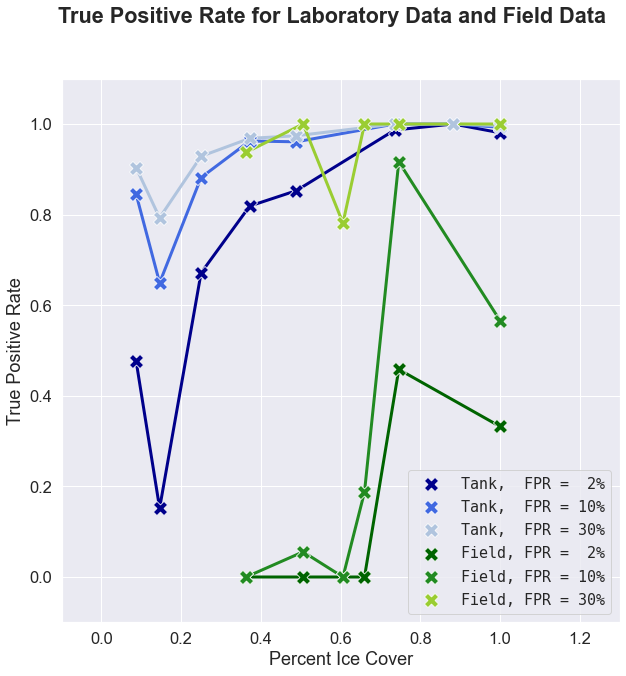

In [1216]:
fig,ax=plt.subplots(figsize=(10,10))
WIDTH = 3
ALPHA = 1
MARKER_SIZE = 200

sns.lineplot(tank_x_list2,   tank_y_list2,  linewidth=WIDTH, alpha=ALPHA, color='darkblue')
sns.lineplot(tank_x_list10,  tank_y_list10, linewidth=WIDTH, alpha=ALPHA, color='royalblue')
sns.lineplot(tank_x_list30,  tank_y_list30, linewidth=WIDTH, alpha=ALPHA, color='lightsteelblue')
sns.lineplot(field_x_list2,  field_y_list2, linewidth=WIDTH, alpha=ALPHA, color='darkgreen')
sns.lineplot(field_x_list10, field_y_list10,linewidth=WIDTH, alpha=ALPHA, color='forestgreen')
sns.lineplot(field_x_list30, field_y_list30,linewidth=WIDTH, alpha=ALPHA, color='yellowgreen')

sns.scatterplot(tank_x_list2,   tank_y_list2,   marker='X', s=MARKER_SIZE, zorder=3, label='Tank,  FPR =  2%', color='darkblue')
sns.scatterplot(tank_x_list10,  tank_y_list10,  marker='X', s=MARKER_SIZE, zorder=3, label='Tank,  FPR = 10%', color='royalblue')
sns.scatterplot(tank_x_list30,  tank_y_list30,  marker='X', s=MARKER_SIZE, zorder=3, label='Tank,  FPR = 30%', color='lightsteelblue')
sns.scatterplot(field_x_list2,  field_y_list2,  marker='X', s=MARKER_SIZE, zorder=3, label='Field, FPR =  2%', color='darkgreen')
sns.scatterplot(field_x_list10, field_y_list10, marker='X', s=MARKER_SIZE, zorder=3, label='Field, FPR = 10%', color='forestgreen')
sns.scatterplot(field_x_list30, field_y_list30, marker='X', s=MARKER_SIZE, zorder=3, label='Field, FPR = 30%', color='yellowgreen')

ax.set_xlim(-0.1,1.3)
ax.set_ylim(-0.1,1.1)
lgnd = plt.legend()
plt.setp(lgnd.texts, family="monospace", size='small')
plt.suptitle('True Positive Rate for Laboratory Data and Field Data', fontweight='bold')

# ax.axis('equal')
ax.set_xlabel('Percent Ice Cover')
ax.set_ylabel('True Positive Rate')
plt.savefig("/Users/zduguid/Desktop/fig/tmp.png")

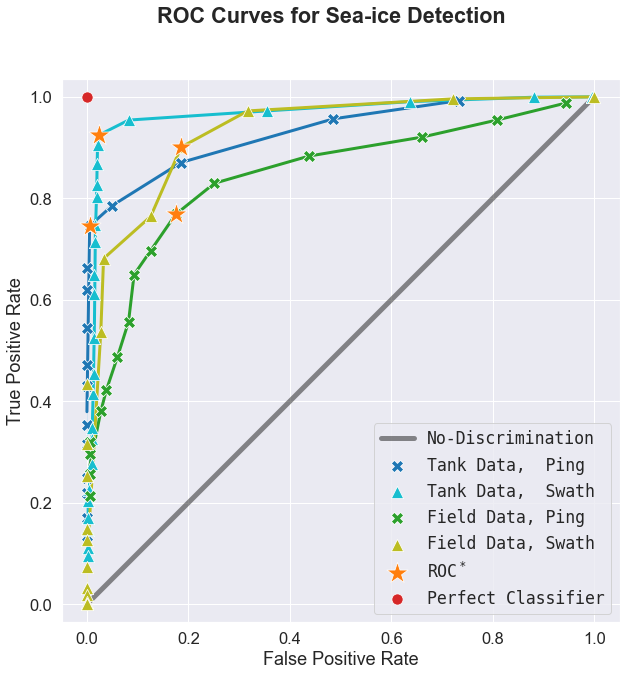

In [1191]:
fig,ax=plt.subplots(figsize=(10,10))
ALPHA       = 1
THICKNESS   = 3
MARKER_SIZE = 150

sns.lineplot(   tank_FPR_list,         tank_TPR_list,         linewidth=THICKNESS, color='tab:blue',  alpha=ALPHA)
sns.lineplot(   tank_FPR_list_swath3,  tank_TPR_list_swath3,  linewidth=THICKNESS, color='tab:cyan',  alpha=ALPHA)
sns.lineplot(   field_FPR_list,        field_TPR_list,        linewidth=THICKNESS, color='tab:green', alpha=ALPHA)
sns.lineplot(   field_FPR_list_swath2, field_TPR_list_swath2, linewidth=THICKNESS, color='tab:olive', alpha=ALPHA)

# sns.lineplot(   tank_FPR_list_swath4,  tank_TPR_list_swath4,  linewidth=THICKNESS, color='tab:purple',  alpha=ALPHA)
# sns.lineplot(   field_FPR_list_swath4, field_TPR_list_swath4, linewidth=THICKNESS, color='tab:purple', alpha=ALPHA)


sns.scatterplot(tank_FPR_list,         tank_TPR_list,         marker='X',          color='tab:blue',  s=MARKER_SIZE, zorder=3, label='Tank Data,  Ping')
sns.scatterplot(tank_FPR_list_swath3,  tank_TPR_list_swath3,  marker='^',          color='tab:cyan',  s=MARKER_SIZE, zorder=3, label='Tank Data,  Swath')
sns.scatterplot(field_FPR_list,        field_TPR_list,        marker='X',          color='tab:green', s=MARKER_SIZE, zorder=3, label='Field Data, Ping')
sns.scatterplot(field_FPR_list_swath2, field_TPR_list_swath2, marker='^',          color='tab:olive', s=MARKER_SIZE, zorder=3, label='Field Data, Swath')

tank_best_TPR  = 0.7456
tank_best_FPR  = 0.0052
field_best_TPR = 0.7683
field_best_FPR = 0.1748
# tank_swath_best_FPR  = 0.0009
# tank_swath_best_TPR  = 0.8482
tank_swath_best_FPR  = 0.0236
tank_swath_best_TPR  = 0.9247
field_swath_best_FPR = 0.1858
field_swath_best_TPR = 0.9010

sns.scatterplot(x=[tank_best_FPR, field_best_FPR],  
                y=[tank_best_TPR, field_best_TPR],  
                color='tab:orange', marker='*', label=r'ROC$^*$', s=500, zorder=4)
sns.scatterplot(x=[tank_swath_best_FPR, field_swath_best_FPR],  
                y=[tank_swath_best_TPR, field_swath_best_TPR],  
                color='tab:orange', marker='*', s=500, zorder=4)
random = np.linspace(0,1,10)
sns.lineplot(random, random, linewidth=5, color='k', alpha=0.5, label='No-Discrimination')
sns.scatterplot(x=[0], y=[1], color='tab:red', marker='.', s=500, zorder=4, label='Perfect Classifier')
# sns.scatterplot([field_best_FPR], [field_best_TPR], color='tab:orange', marker='*', s=500, zorder=5)

lgnd = plt.legend()
plt.setp(lgnd.texts, family="monospace")

ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.axis('equal')
plt.suptitle('ROC Curves for Sea-ice Detection', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

---
## Micron Beam Cross-Section

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,5))

res        = 50
r_min      = 1 
deg_to_rad = np.pi/180

def f(phi,theta):
    return(r_min/np.cos(phi*deg_to_rad)/np.cos(theta*deg_to_rad))

# define the coordinate system of the traced beam
v_angle = 35
h_angle = 3 
v_width = np.linspace(-(v_angle/2), (v_angle/2), res)
h_width = np.linspace(-(h_angle/2), (h_angle/2), res)

# set up meshgrid 
X,Y     = np.meshgrid(v_width,h_width)
Z = np.zeros((res,res))
for i in range(res):
    for j in range(res):
        Z[i,j] = f(X[i,j],Y[i,j])

print(np.max(Z))
print(np.min(Z))
print(np.mean(Z))
print(np.median(Z))
        
img = plt.pcolor(X, Y, Z, cmap='viridis')
fig.colorbar(img)
ax.axis('equal')
ax.set_title('Slant Range Multiplier for Micron Sonar Beam', 
             fontsize=22, fontweight='bold')
ax.set_xlabel('Vertical Angle [deg]')
ax.set_ylabel('Horizontal Angle [deg]')
# plt.savefig("../figs/%s.png" % ('slant-range-multiplier'))

---
## Normalizing Intensity

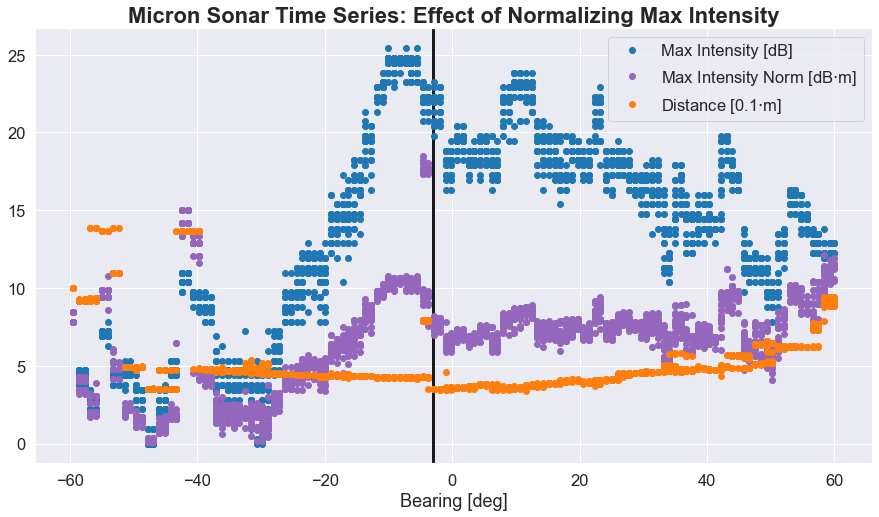

In [20]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# # normalizing between zero and 1 
# time_series.df['max_intensity']/np.max(time_series.df['max_intensity'])
# time_series.df['max_intensity_norm']/np.max(time_series.df['max_intensity_norm'])

ax.plot(ts.df['bearing'], 
        ts.df['max_intensity'],
        'o', color='tab:blue')

ax.plot(ts.df['bearing'], 
        ts.df['max_intensity_norm'],
        'o', color='tab:purple')

ax.plot(ts.df['bearing'], 
        ts.df['peak_start']*10,
        'o', color='tab:orange')

ax.set_title('Micron Sonar Time Series: Effect of Normalizing Max Intensity', 
             fontsize=22, fontweight='bold')

plt.axvspan(separator-0.1, separator+0.1, color='k')

ax.set_xlabel('Bearing [deg]')
# ax.set_ylabel('Intensity [dB], Norm Intensity[dB$\cdot$m]')
ax.legend(['Max Intensity [dB]', 
           'Max Intensity Norm [dB$\cdot$m]', 
           'Distance [0.1$\cdot$m]'], loc='best')
# plt.savefig("../figs/%s.png" % ('normalized-intensity6'))

---
## Down-Selecting a Swath from the Time Series 

In [ ]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

deg_in_circle = 360
left  = ts_new.df['left_lim'][0]
right = ts_new.df['right_lim'][0]
if (left-right) < 0:
    left += deg_in_circle

steps  = ts_new.df['steps'][0]
steps += -0.1
swath1 = math.ceil(abs(right-left)/steps)
swath2 = math.ceil(abs(60+60)/steps)

test_df = ts_new.df[:swath2]



ax.set_title('Down-Selecting a Single Swath from a Micron Sonar File', 
             fontsize=22, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Bearing [deg]')

plt.plot(ts.df.bearing, 'o')
plt.plot(ts_new.df.bearing, 'o')
plt.plot(ts.df.bearing[:swath1],'o')
plt.plot(ts_new.df.bearing[:swath2],'o')
plt.legend(['Multiple Swaths, Full Bearing', 
            'Multiple Swaths, Cropped Bearing', 
            'Single Swath, Full Bearing', 
            'Multiple Swaths, Cropped Bearing'])
# plt.savefig("../figs/%s.png" % ('down-selecting-swath'))

---
## Three View

In [ ]:

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(3,figsize=(15,15))
ax[0].plot(time_series.df['bearing_ref_world']-90, time_series.df['peak_start']*np.cos((time_series.df['bearing_ref_world']-90)*np.pi/180), 'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set(xlabel='Incidence Angle [deg]')
ax[0].set_xlabel('Peak Width [m]')
ax[1].plot(time_series.df['incidence_angle'], time_series.df['max_intensity']*time_series.df['max_intensity_bin'],'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set_xlabel('Max Intensity [db]')
ax[2].plot(time_series.df['max_intensity']/time_series.df['max_intensity_bin'], time_series.df['peak_width'], 'o')
ax[0].set_xlabel('Max Intensity [db]')
ax[0].set_xlabel('Peak Width [m]')
# plt.savefig("../figs/%s.png" % ('tmp2'))

---
## Computing Ice Thickness 

0.4255327157700856
0.3595874835233397
0.06594523224674592

0.1362913609738086
0.011188244028141338


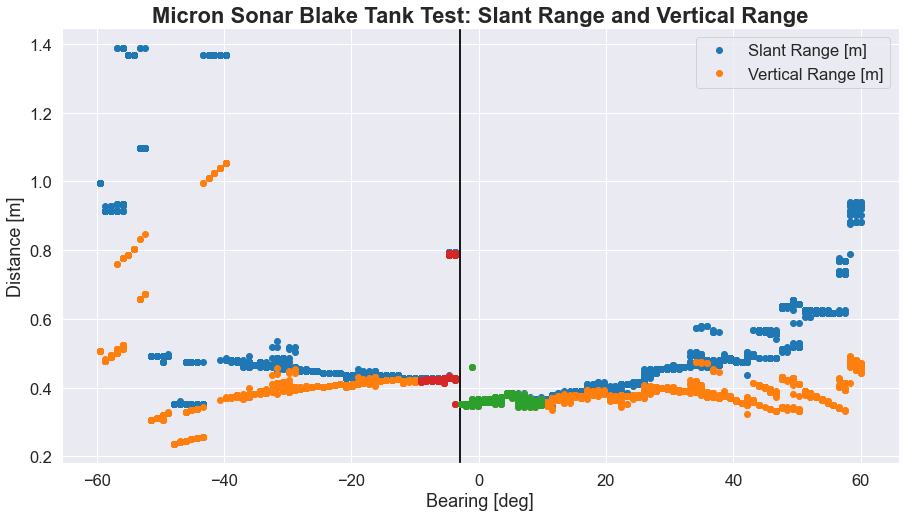

In [17]:
time_series = ts
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(time_series.df.bearing_ref_world, time_series.df.peak_start, 'o', color='tab:blue')
plt.plot(time_series.df.bearing_ref_world, time_series.df.vertical_range, 'o', color='tab:orange')

ax.set_title('Micron Sonar Blake Tank Test: Slant Range and Vertical Range', 
             fontsize=22, fontweight='bold')

plt.axvspan(separator-0.1, separator+0.1, color='k')

# water = 0.42
ice   = 0.35962075787747666
std   = 0.02
# plt.axhspan(water-0.001, water+0.001, color='k')
# plt.axhspan(ice-std,     ice+std, color='tab:purple', alpha=0.5)
window = 10

water_edge = time_series.df[(time_series.df.bearing_ref_world > -window) &
                            (time_series.df.bearing_ref_world <  separator)]
ice_edge   = time_series.df[(time_series.df.bearing_ref_world >  separator) &
                            (time_series.df.bearing_ref_world <  window)]

water_dist = np.median(water_edge.vertical_range)
ice_dist   = np.median(ice_edge.vertical_range)
print(water_dist)
print(ice_dist)
print(water_dist-ice_dist)
print()
print(np.std(water_edge.vertical_range))
print(np.std(ice_edge.vertical_range))

plt.plot(water_edge.bearing_ref_world, water_edge.vertical_range, 'o', color='tab:red')
plt.plot(ice_edge.bearing_ref_world, ice_edge.vertical_range, 'o', color='tab:green')
ax.set_xlabel('Bearing [deg]')
ax.set_ylabel('Distance [m]')
ax.legend(['Slant Range [m]', 
           'Vertical Range [m]'], loc='best')
# plt.savefig("../figs/%s.png" % ('ice-thickness-6.5cm'))


---
##  Determine Ice Percent Cover

In [ ]:
# open the file 
file = "/Users/zduguid/Desktop/MIZ-Blake-Tank/3-ice-water-color/miz2-red-blue.jpg"
img = Image.open(file)
img = np.array(img)

# separate the three channels of the image
RED, GREEN, BLUE = (0, 1, 2)
reds   = img[:, :, RED]
greens = img[:, :, GREEN]
blues  = img[:, :, BLUE]

# # Mask image based on RGB value
# mask_reds  = (reds  > 130) & (greens < 100) & (blues < 100)
mask_reds  = (reds == 204)  & (greens == 0) & (blues == 1)
mask_blues = (reds == 0)    & (greens == 0) & (blues == 204)

# create masked images for visual confirmation
empty_img_reds  = np.zeros_like(img)
empty_img_blues = np.zeros_like(img)
empty_img_reds[mask_reds]   = (204,0,0)
empty_img_blues[mask_blues] = (0,0,204)

# count pixels to estimate ice cover
red_count  = np.sum(mask_reds)
blue_count = np.sum(mask_blues)
ice_percent = 100* red_count / (red_count + blue_count)
print('ice percent: %f' % ice_percent)

# display the image products
display(Image.fromarray(img))
display(Image.fromarray(empty_img_reds))
display(Image.fromarray(empty_img_blues))

---
## Selecting Ensembles to Plot

In [ ]:
"""
    # store current angle and rounded angle 
    angle_current         = data_array[data_lookup['Bearing']]
    angle_current_rounded = math.floor(angle_current/angle_increment)*angle_increment
    
    # TODO make this a sub-method
    # compute the change in angle since a plot has been generated 
    if (not angle_previous): 
        angle_delta = 0
    else:  
        # add change current angle difference to the running sum since last plot 
        if angle_current - angle_previous > 0:
            angle_delta += angle_current - angle_previous 
        # account for instance where 
        else: 
            angle_delta += angle_current + deg_in_circle - angle_previous 
    
    # update previous angle 
    angle_previous = angle_current 
    
    # generate plot for every 20 degrees, avoid replotting area already plotted
    if ((angle_current_rounded % angle_increment == 0) and 
        (angle_delta > angle_increment/2) and 
        (angle_current_rounded not in angles_plotted) and 
        (plot_on)):
"""
z = 5

---
## Playing with Bit-Encoding of Micron Data

In [ ]:
int("8923", 16)
int("16", 16)
bin(int("16", 16))
bin(8923)

bin(16971)[2:][::-1]
int('1101001001000010'[::-1],2)

# 8923 hex -> 0b   1000 1001 0010 0011
# 8923 int -> 0b   0010 0010 1101 1011'

# 8967 hex -> 0b   1000 1001 0110 0111
# 8967 int -> 0b   0010 0011 0000 0111'

# 144  hex -> 0b 1 0100 0100
# 144  int -> 0b   1001 0000
# 16   hex -> 0b   0001 0110

# print(header[14], row1[14]) # column 14 is the number of data points in the scanline 
# print(header[15], row1[15]) # column 15 is the first value of an array DBytes long